In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import tensorflow as tf
import string
import random
import os
import math
from timeit import default_timer as timer
from tqdm import tqdm, trange, tqdm_notebook

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Using TensorFlow backend.


In [2]:
def plot_curves(title, data, y_title, x_title='Epoch', legend=[], x_labels_offset = 0):
    fig = plt.figure(figsize=(8, 4))
        
    for row in data:
        x = range(x_labels_offset, len(row))
        plt.plot(x, row[x_labels_offset:])
    
    plt.title(title)
    plt.ylabel(y_title)
    plt.xlabel(x_title)
    plt.grid(True)
    plt.legend(legend, loc='upper left')
    plt.show()

In [3]:
def predicted_to_df_and_to_file(predicted, filename):    
    ids = []
    values = []
    
    for idx, val in enumerate(predicted):
        ids.append(idx + 1)
        values.append(val[0])
    
    df = pd.DataFrame({'id': ids, 'label': values})
    
    df.to_csv(f"{filename}_submission.csv", index=False, float_format='%.3f')
    
    return df

In [4]:
prepared_path = './data/prepared'

In [5]:
WIDTH = 180
HEIGHT = 180
IMG_SIZE = (WIDTH, HEIGHT)
CHANNELS = 3

In [6]:
test_data_path = './data/test'
test_files = os.listdir(test_data_path)
test_data = []
for test_file in test_files:
    full_path = f'{test_data_path}/{test_file}'
    img_data = img_to_array(load_img(full_path, target_size=IMG_SIZE))
    test_data.append(img_data)

test_data = np.array(test_data) / 255
#test_data = test_data[: 1000]
test_data.shape

(12500, 180, 180, 3)

In [40]:
class BaseModel():
    def __init__(self):
        self.init_basic_params()
        
        self.compile()
        
        self.tf_writer.add_graph(self.session.graph)
    
    def rand_str(self, str_len=20):
        return ''.join(random.choices(string.ascii_uppercase + string.digits, k=str_len))
    
    def init_basic_params(self):
        tf.reset_default_graph()
        self.logs_path = './tf_board/' + self.__class__.__name__
        self.var_scope = self.rand_str()
        self.print_separator = '-' * 65
        self.session = None
        self.dropout_rate_tf = tf.placeholder(tf.float32)
        self.dropout_rate_tf_cnn = tf.placeholder(tf.float32)
        
        self.input_size = [WIDTH, HEIGHT, CHANNELS]
        self.output_size = 1
        
        self.dropout_rate = 0.15
        self.dropout_rate_cnn = 0.15
        
        self.start_learning_rate = 0.01
        
        self.tf_writer = tf.summary.FileWriter(self.logs_path)
    
    def __del__(self): 
        print('object del')
        if self.session:
            tf.reset_default_graph()
            self.session.close()
    
    def reset_internal_params(self):
        self.hidden_layers = {}
        self.hidden_layers_W = {}
        self.hidden_layers_b = {}
        self.history = {
            'acc_train': [],
            'acc_valid': [],
            'loss_train': [],
            'loss_valid': []
        }
        
        self.global_step = tf.Variable(0, trainable=False)
        self.decay_steps = tf.Variable(100000, trainable=False)
    
    def get_W(self, layer_id, shape):
        #with tf.variable_scope(self.var_scope, reuse=tf.AUTO_REUSE):
        #W = tf.Variable(tf.truncated_normal(shape, stddev=0.1, mean=0), name=f'W_{layer_id}')
        initializer = tf.contrib.layers.variance_scaling_initializer()
        W = tf.Variable(initializer(shape), name=f'W_{layer_id}')
        self.hidden_layers_W[layer_id] = W

        return self.hidden_layers_W[layer_id]

    def get_b(self, layer_id, shape):
        #with tf.variable_scope(self.var_scope, reuse=tf.AUTO_REUSE):
        self.hidden_layers_b[layer_id] = tf.Variable(tf.zeros(shape), name=f'b_{layer_id}')
        
        return self.hidden_layers_b[layer_id]
        
    def get_dense_layer(self, layer_id, prev_layer, units_count, activ=tf.nn.relu):
        input_size = prev_layer.get_shape().as_list()[1]
        
        W = self.get_W(layer_id, [input_size, units_count])
        b = self.get_b(layer_id, [units_count])
        
        layer = tf.matmul(prev_layer, W) + b
        
        if activ:
            layer = activ(layer, name=f'Lay_Dense_{layer_id}')
        
        return layer
    
    def get_conv2_layer(self, layer_id, prev_layer, kernel_size, output_channels, strides=1, padding='SAME', activ=tf.nn.relu):
        input_channels = prev_layer.get_shape().as_list()[3]
        
        # 5x5 conv, 1 input, 32 outputs
        # [filter_height, filter_width, in_channels, out_channels]
        filter_shape = [kernel_size[0], kernel_size[1], input_channels, output_channels]

        W = self.get_W(layer_id, filter_shape)
        b = self.get_b(layer_id, [output_channels])
        
        layer = tf.nn.conv2d(prev_layer, W, [1, strides, strides, 1], padding) + b
        
        if activ:
            layer = activ(layer, name=f'Lay_Conv2d_{layer_id}')  
        
        return layer
    
    def flatten(self, input):
        shape = input.get_shape().as_list()
        shape = np.array(shape)
        size = shape[shape != None].prod()
        
        return tf.reshape(input, [-1, size], name='Flatten')
    
    def batch_norm(self, input):
        #return tf.contrib.layers.batch_norm(input, fused=True, data_format='NCHW')
        return tf.contrib.layers.batch_norm(input)
    
    def get_max_pooling(self, layer_id, input, ksize, stride=1, padding='SAME'):
        return tf.nn.max_pool(input, [1, ksize, ksize, 1], [1, stride, stride, 1], padding, name=f'max_pool_{layer_id}')

    def get_avg_pooling(self, layer_id, input, ksize, stride=1, padding='SAME'):
        return tf.nn.avg_pool(input, [1, ksize, ksize, 1], [1, stride, stride, 1], padding, name=f'avg_pool_{layer_id}')
    
    def pre_compile():
        print('precompile')
    
    def next_batch(self, x, y, batch_size, iteration):
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        
        return x[start:end], y[start:end]
    
    def l2_reg(self, loss_rate=0.01):
        reg_sum = 0
        for key in self.hidden_layers_W:
            reg_sum += tf.nn.l2_loss(self.hidden_layers_W[key])
        
        return loss_rate * reg_sum
    
    def compile(self):
        
        self.lr = tf.placeholder(tf.float32, shape=[])
        
        self.pre_compile()
        
        self.prediction_proba = tf.nn.sigmoid(self.layer_output, name='Output')
        self.prediction = tf.round(self.prediction_proba)
        
        #self.accuracy = tf.reduce_mean(
        #    tf.cast(
        #        tf.equal(tf.argmax(self.prediction, 1), tf.argmax(self.expected_output, 1)),
        #        tf.float32,
        #    ),
        #    name='Accuracy'
        #)
        
        self.accuracy = tf.reduce_mean(
            tf.cast(
                tf.equal(self.prediction, self.expected_output), 
                tf.float32
            ),
            name='Accuracy'
        )
                
        self.session = tf.Session()
        self.vars = tf.global_variables_initializer()
        self.session.run(tf.global_variables_initializer())
    
    def fit_gen(self, train_gen, valid_gen=None, epochs=1):
        
        fit_start = timer()
        
        iterations = train_gen.__len__()
        batch_size = train_gen.batch_size
            
        print(self.print_separator)
        print(f'Epochs: {epochs}\t| Iterations: {iterations}\t| Batch: {batch_size}')
        print(self.print_separator)
        
        for epoch in range(epochs):
            
            start = timer()
            loss_train = 0
            acc_train = 0
            
            with trange(iterations) as t:
                for iteration in t:
                    x_batch, y_batch = train_gen.__getitem__(iteration)
                    
                    #loss_container = []
                    #acc_container = []
                    
                    feed_data = { 
                        self.input: x_batch, 
                        self.expected_output: y_batch.reshape([-1, self.output_size]),
                        self.dropout_rate_tf: self.dropout_rate,
                        self.dropout_rate_tf_cnn: self.dropout_rate_cnn
                    }

                    self.session.run(self.optimizer, feed_dict=feed_data)


                    feed_data_metrics = { 
                        self.input: x_batch, 
                        self.expected_output: y_batch.reshape([-1, self.output_size]),
                        self.dropout_rate_tf: 0,
                        self.dropout_rate_tf_cnn: 0
                    }

                    loss, acc = self.session.run([self.loss, self.accuracy], feed_dict=feed_data_metrics)

                    #loss_container.append(loss)
                    #acc_container.append(acc)
                    
                    loss_train += loss / iterations
                    acc_train += acc / iterations
                    #loss_train = np.mean(loss_container)
                    #acc_train = np.mean(acc_container)
                    
                    t.set_description(f'Epoch: {epoch + 1}')

                    t.set_postfix(loss=f'{loss_train:.5f}', acc=f'{acc_train:.02%}')

                    #if iteration % 20 == 0 and iteration > 0:
                    #    print(f'iteration: {iteration}')
                

            #loss_train, acc_train = self.evaluate_gen(train_gen)
        
            self.history['loss_train'].append(loss_train)            
            self.history['acc_train'].append(acc_train)
            
            
            if valid_gen != None:
                loss_valid, acc_valid = self.evaluate_gen(valid_gen)
        
                self.history['loss_valid'].append(loss_valid)
                self.history['acc_valid'].append(acc_valid)
            
            end = timer()
            
            epoch_time = end - start
            
            if valid_gen != None:
                print(f'Epoch {epoch + 1}: ({epoch_time:.5f} s) \t loss - Tr[{loss_train:.5f}] Va[{loss_valid:.5f}] \t acc - Tr[{acc_train:.02%}] Va[{acc_valid:.02%}]')
            else:
                print(f'Epoch {epoch + 1}: ({epoch_time:.5f} s) \t loss - Tr[{loss_train:.5f}] \t acc - Tr[{acc_train:.02%}]')
                
            print(self.print_separator)
        
        fit_end = timer()
        
        epoch_time = fit_end - fit_start
        print(f'Finished in: {epoch_time:.4f} s')
        
    def evaluate_gen(self, eval_gen):
        loss = 0
        acc = 0

        iterations = eval_gen.__len__()
        
        for iteration in range(iterations):
            x_batch, y_batch = eval_gen.__getitem__(iteration)
            feed_data = { 
                    self.input: x_batch, 
                    self.expected_output: y_batch.reshape([-1, self.output_size]),
                    self.dropout_rate_tf: 0,
                    self.dropout_rate_tf_cnn: 0
                }
                
            batch_loss, batch_acc = self.session.run([self.loss, self.accuracy], feed_dict=feed_data)
            
            acc += batch_acc / iterations
            loss += batch_loss / iterations
                
        return loss, acc 
    
    def evaluate(self, x=None, y=None):
        feed_data = { self.input: x, self.expected_output: y, self.dropout_rate_tf: 0, self.dropout_rate_tf_cnn: 0}
        return self.session.run([self.loss, self.accuracy], feed_dict=feed_data)
    
    def predict(self, x, batch_size=None):
        if batch_size is None:
            feed_data = { self.input: x, self.dropout_rate_tf: 0}
            return self.session.run(self.prediction, feed_dict=feed_data)
        
        

    def predict_proba(self, x, batch_size=None):
        if batch_size is None:
            feed_data = { self.input: x, self.dropout_rate_tf: 0, self.dropout_rate_tf_cnn: 0}
            return self.session.run(self.prediction_proba, feed_dict=feed_data)
        
        output = []
        
        iterations = math.ceil(len(x) / batch_size)
        for iteration in range(iterations):
            x_batch, _ = self.next_batch(x, x, batch_size, iteration)
            feed_data = { self.input: x_batch, self.dropout_rate_tf: 0, self.dropout_rate_tf_cnn: 0}
            result = self.session.run(self.prediction_proba, feed_dict=feed_data)
            output.append(result)
        
        return np.vstack(output)
    

In [41]:
class Model1(BaseModel):
    def __init__(self):
        BaseModel.__init__(self)

    def init_basic_params(self):
        super().init_basic_params()
        self.dropout_rate = 0.2
        self.dropout_rate_cnn = 0.0
        self.start_learning_rate = 0.001
        
    def pre_compile(self):
        self.reset_internal_params()

        self.input = tf.placeholder(tf.float32, shape=[None, *self.input_size], name="Input")
        self.expected_output = tf.placeholder(tf.float32, shape=[None, self.output_size], name="Y_actual")
   
        out = self.get_conv2_layer(1, self.input, [4, 4], 32)
        out = self.batch_norm(out)
        out = self.get_max_pooling(2, out, 2, stride=2)
        out = tf.nn.dropout(out, rate=self.dropout_rate_tf_cnn)
    
        out = self.get_conv2_layer(3, out, [4, 4], 64)
        out = self.batch_norm(out)
        out = self.get_max_pooling(4, out, 2, stride=2)
        out = tf.nn.dropout(out, rate=self.dropout_rate_tf_cnn)
        
        
        out = self.get_conv2_layer(7, out, [4, 4], 128)
        out = self.batch_norm(out)
        out = self.get_max_pooling(8, out, 2, stride=2)
        
        #out = tf.nn.dropout(out, rate=self.dropout_rate_tf_cnn)
        
        #out = self.get_conv2_layer(9, out, [1, 1], 256)
        
        #out = tf.nn.dropout(out, rate=self.dropout_rate_tf_cnn)
        #out = self.get_conv2_layer(7, out, [5, 5], 256)
        #out = self.batch_norm(out)
        #out = self.get_max_pooling(8, out, 2, stride=2)
        
        #out = tf.nn.dropout(out, rate=self.dropout_rate_tf_cnn)
        #out = self.get_conv2_layer(9, out, [1, 1], 512)

        out = self.flatten(out)
        
        #out = tf.nn.dropout(out, rate=self.dropout_rate_tf)

        out = self.get_dense_layer(10, out, 128)
        
        out = tf.nn.dropout(out, rate=self.dropout_rate_tf)

        out = self.get_dense_layer(11, out, 128)
        
        out = tf.nn.dropout(out, rate=self.dropout_rate_tf)
        
        out = self.get_dense_layer(12, out, self.output_size, activ=None)

        self.layer_output = out
        
        self.loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(labels=self.expected_output, logits=self.layer_output),
            name='Loss'
        ) #+ self.l2_reg(loss_rate=0.001)
        
        #self.optimizer = tf.train.RMSPropOptimizer(self.start_learning_rate).minimize(self.loss, global_step=self.global_step)
        self.optimizer = tf.train.AdamOptimizer(self.start_learning_rate).minimize(self.loss, global_step=self.global_step)

In [43]:
BATCH_SIZE=64
VALID_BATCH_SIZE=512
EPOCH=20
TR_LAERN_EPOCH = 10

In [10]:
o_data_gen = ImageDataGenerator(rescale=1.0/255.0)
o_train_gen = o_data_gen.flow_from_directory(f'{prepared_path}/train/', class_mode='binary', batch_size=BATCH_SIZE, target_size=IMG_SIZE)
o_valid_gen = o_data_gen.flow_from_directory(f'{prepared_path}/valid/', class_mode='binary', batch_size=VALID_BATCH_SIZE, target_size=IMG_SIZE)
o_test_gen = o_data_gen.flow_from_directory(f'{prepared_path}/test/', class_mode='binary', batch_size=VALID_BATCH_SIZE, target_size=IMG_SIZE)

Found 17000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [11]:
def print_test(title, model):
    orig_test_loss, orig_test_acc = model.evaluate_gen(o_test_gen)

    print(f'{title}: loss - {orig_test_loss:.4f}\t Acc - {orig_test_acc:.02%}')

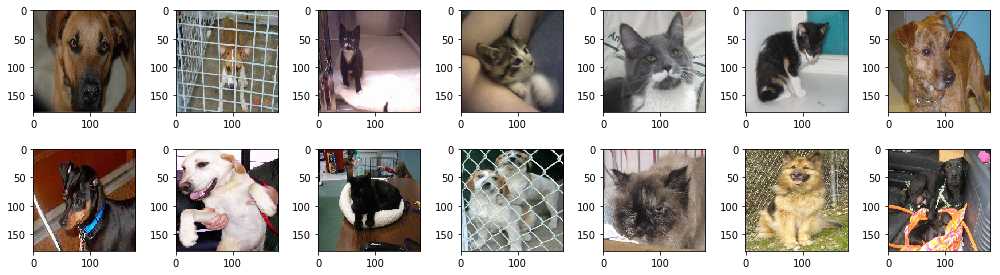

In [12]:
plt.figure(figsize=(14, 4))
for i in range(0, 14):
    plt.subplot(2, 7, i+1)
    for X_batch, Y_batch in o_train_gen:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [44]:
orig_model_1 = Model1()
orig_model_1.fit_gen(o_train_gen, o_valid_gen, epochs=EPOCH)

  0%|          | 0/266 [00:00<?, ?it/s]

-----------------------------------------------------------------
Epochs: 20	| Iterations: 266	| Batch: 64
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 1: (206.78556 s) 	 loss - Tr[0.96832] Va[0.67273] 	 acc - Tr[56.48%] Va[55.20%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 2: (206.10520 s) 	 loss - Tr[0.67445] Va[0.68053] 	 acc - Tr[54.71%] Va[52.62%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 3: (205.72645 s) 	 loss - Tr[0.66514] Va[0.67129] 	 acc - Tr[55.76%] Va[54.67%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 4: (205.48113 s) 	 loss - Tr[0.65449] Va[0.64073] 	 acc - Tr[58.18%] Va[60.00%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 5: (207.47777 s) 	 loss - Tr[0.64537] Va[0.65340] 	 acc - Tr[58.94%] Va[57.75%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 6: (205.78213 s) 	 loss - Tr[0.63600] Va[0.63283] 	 acc - Tr[60.89%] Va[61.09%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 7: (204.96925 s) 	 loss - Tr[0.62210] Va[0.63497] 	 acc - Tr[62.66%] Va[62.21%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 8: (205.90363 s) 	 loss - Tr[0.60372] Va[0.60294] 	 acc - Tr[66.07%] Va[66.73%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 9: (206.38124 s) 	 loss - Tr[0.57756] Va[0.58054] 	 acc - Tr[69.95%] Va[68.94%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 10: (206.37078 s) 	 loss - Tr[0.53680] Va[0.54567] 	 acc - Tr[74.44%] Va[72.60%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 11: (207.86222 s) 	 loss - Tr[0.50958] Va[0.52932] 	 acc - Tr[76.63%] Va[75.03%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 12: (205.52440 s) 	 loss - Tr[0.48388] Va[0.52627] 	 acc - Tr[78.34%] Va[75.34%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 13: (206.88628 s) 	 loss - Tr[0.46595] Va[0.49003] 	 acc - Tr[79.65%] Va[77.86%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 14: (206.47640 s) 	 loss - Tr[0.43173] Va[0.45992] 	 acc - Tr[81.68%] Va[78.81%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 15: (205.42513 s) 	 loss - Tr[0.43369] Va[0.42524] 	 acc - Tr[81.18%] Va[80.68%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 16: (207.77204 s) 	 loss - Tr[0.39730] Va[0.41674] 	 acc - Tr[83.55%] Va[82.28%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 17: (207.43666 s) 	 loss - Tr[0.36387] Va[0.41386] 	 acc - Tr[85.44%] Va[82.20%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 18: (206.80319 s) 	 loss - Tr[0.31360] Va[0.37871] 	 acc - Tr[88.35%] Va[84.07%]
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 19: (205.53580 s) 	 loss - Tr[0.28289] Va[0.36071] 	 acc - Tr[89.85%] Va[85.29%]
-----------------------------------------------------------------


Epoch: 20: 100%|██████████| 266/266 [02:58<00:00,  1.49it/s, acc=91.49%, loss=0.24833]


Epoch 20: (205.76683 s) 	 loss - Tr[0.24833] Va[0.36899] 	 acc - Tr[91.49%] Va[85.14%]
-----------------------------------------------------------------
Finished in: 4126.4803 s


In [45]:
print_test('Original model', orig_model_1)

Original model: loss - 0.3665	 Acc - 85.62%


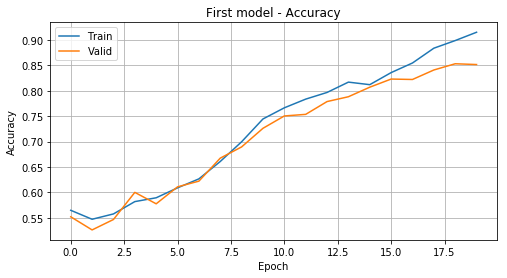

In [46]:
plot_curves(f'First model - Accuracy', [orig_model_1.history['acc_train'], orig_model_1.history['acc_valid']], 'Accuracy', 'Epoch', ['Train', 'Valid'])


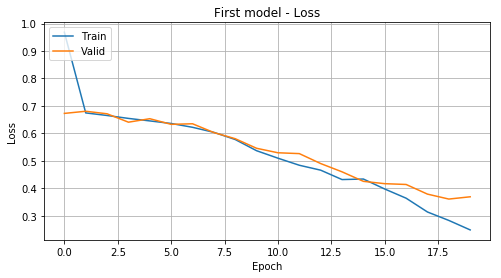

In [47]:
plot_curves(f'First model - Loss', [orig_model_1.history['loss_train'], orig_model_1.history['loss_valid']], 'Loss', 'Epoch', ['Train', 'Valid'])


In [48]:
orig_predicted_proba = orig_model_1.predict_proba(test_data, batch_size = 1024)

In [49]:
df = predicted_to_df_and_to_file(orig_predicted_proba, 'orig_predicted')
df.head()

id     label
0   1  0.977365
1   2  0.138262
2   3  0.119689
3   4  0.119689
4   5  0.464931

# dat augmentation

In [66]:
aug_data_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

aug_train_gen = aug_data_gen.flow_from_directory(f'{prepared_path}/train/', class_mode='binary', batch_size=BATCH_SIZE, target_size=IMG_SIZE)


Found 17000 images belonging to 2 classes.


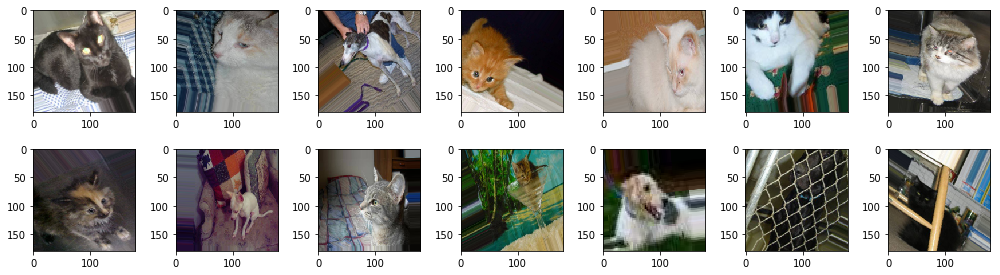

In [67]:
plt.figure(figsize=(14, 4))
for i in range(0, 14):
    plt.subplot(2, 7, i+1)
    for X_batch, Y_batch in aug_train_gen:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [68]:
aug_model_1 = Model1()
aug_model_1.fit_gen(aug_train_gen, o_valid_gen, epochs=EPOCH)

  0%|          | 0/266 [00:00<?, ?it/s]

-----------------------------------------------------------------
Epochs: 20	| Iterations: 266	| Batch: 64
-----------------------------------------------------------------


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 1: (324.29135 s) 	 loss - Tr[1.06951] Va[0.69282] 	 acc - Tr[52.41%] Va[50.58%]
-----------------------------------------------------------------


Epoch: 2:  71%|███████   | 189/266 [03:29<01:25,  1.11s/it, acc=35.93%, loss=0.49233]


KeyboardInterrupt: 

In [ ]:
print_test('Aug model', aug_model_1)

In [ ]:
plot_curves(f'Aug model - Accuracy', [aug_model_1.history['acc_train'], aug_model_1.history['acc_valid']], 'Accuracy', 'Epoch', ['Train', 'Valid'])


In [ ]:
plot_curves(f'Aug model - Loss', [aug_model_1.history['loss_train'], aug_model_1.history['loss_valid']], 'Loss', 'Epoch', ['Train', 'Valid'])


In [ ]:
aug_predicted_proba = aug_model_1.predict_proba(test_data, batch_size = 1024)

In [ ]:
df = predicted_to_df_and_to_file(orig_predicted_proba, 'aug_predicted')
df.head()

# Transfer Learning

In [69]:
import tensorflow.keras as keras

In [70]:
vgg16 = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, CHANNELS))

58892288/58889256 [==============================] - 3s 0us/step


In [71]:
vgg16.trainable = True
trainable = False
for layer in vgg16.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

In [72]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

In [73]:
tr_l_model = keras.Sequential()

tr_l_model.add(vgg16)
tr_l_model.add(keras.layers.Flatten())
tr_l_model.add(keras.layers.Dense(128, activation='relu'))
tr_l_model.add(keras.layers.Dropout(0.5))
tr_l_model.add(keras.layers.Dense(128, activation='relu'))
tr_l_model.add(keras.layers.Dropout(0.5))
tr_l_model.add(keras.layers.Dense(1, activation='sigmoid'))

tr_l_model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=1e-5), 
              metrics=['accuracy'])

In [74]:
tr_l_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1638528   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [76]:
tr_l_model.fit_generator(
    aug_train_gen,
    steps_per_epoch=len(aug_train_gen),
    epochs=TR_LAERN_EPOCH,
    validation_data=o_valid_gen,
    validation_steps=len(o_valid_gen)
)

Epoch 1/10
266/266 [==============================] - 280s 1s/step - loss: 0.4792 - acc: 0.7665 - val_loss: 0.2509 - val_acc: 0.8915
Epoch 2/10
266/266 [==============================] - 237s 890ms/step - loss: 0.3146 - acc: 0.8721 - val_loss: 0.1883 - val_acc: 0.9200
Epoch 3/10
266/266 [==============================] - 236s 887ms/step - loss: 0.2535 - acc: 0.8966 - val_loss: 0.1714 - val_acc: 0.9312
Epoch 4/10
266/266 [==============================] - 235s 882ms/step - loss: 0.2181 - acc: 0.9118 - val_loss: 0.1482 - val_acc: 0.9452
Epoch 5/10
266/266 [==============================] - 237s 890ms/step - loss: 0.2035 - acc: 0.9200 - val_loss: 0.1660 - val_acc: 0.9367
Epoch 6/10
266/266 [==============================] - 236s 888ms/step - loss: 0.1904 - acc: 0.9257 - val_loss: 0.1368 - val_acc: 0.9488
Epoch 7/10
266/266 [==============================] - 237s 891ms/step - loss: 0.1739 - acc: 0.9333 - val_loss: 0.1259 - val_acc: 0.9513
Epoch 8/10
266/266 [==============================]

In [77]:
tr_l_loss, tr_l_acc = tr_l_model.evaluate_generator(o_test_gen, steps=len(o_test_gen))
tr_l_loss, tr_l_acc

(0.11187903117388487, 0.9575)

In [78]:
print(f'Transfer Learning vgg16: loss - {tr_l_loss:.4f}\t Acc - {tr_l_acc:.02%}')

Transfer Learning vgg16: loss - 0.1119	 Acc - 95.75%


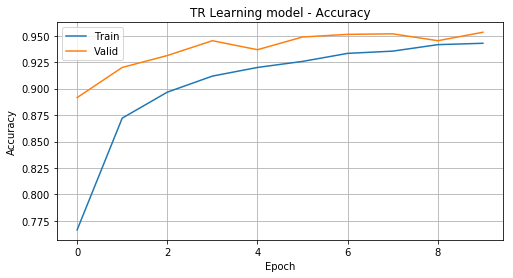

In [79]:
plot_curves(f'TR Learning model - Accuracy', [tr_l_model.history.history['acc'], tr_l_model.history.history['val_acc']], 'Accuracy', 'Epoch', ['Train', 'Valid'])


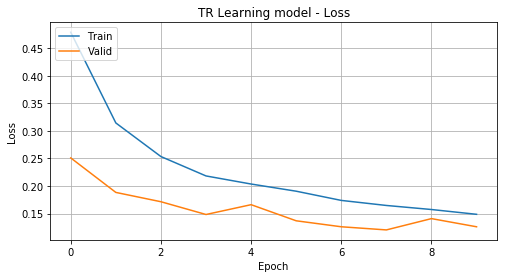

In [80]:
plot_curves(f'TR Learning model - Loss', [tr_l_model.history.history['loss'], tr_l_model.history.history['val_loss']], 'Loss', 'Epoch', ['Train', 'Valid'])


In [81]:
tr_l_predicted_proba = tr_l_model.predict_proba(test_data)

In [82]:
df = predicted_to_df_and_to_file(tr_l_predicted_proba, 'tr_l_predicted')
df.head()

id     label
0   1  0.999048
1   2  0.003527
2   3  0.000006
3   4  0.000332
4   5  0.000062

In [83]:
_, orig_test_acc = orig_model_1.evaluate_gen(o_test_gen)

In [84]:
_, orig_test_acc

(0.3667185977101326, 0.8572528511285782)

In [ ]:
_, aug_test_acc = aug_model_1.evaluate_gen(o_test_gen)

In [ ]:
labels = ['Original', 'Augmentation', 'VGG16']
test_acc = [orig_test_acc, aug_test_acc, tr_l_acc]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels,test_acc, color=['Blue', 'Orange', 'Green'])
plt.ylim(0.94, 0.965)
plt.show()